## Processed Shots Data Exploration
Notebook to plot the data in the processed shots, located on tigress

### Imports and constants

In [1]:
import numpy as np
import pandas as pd
import time
import scipy.signal
from pprint import pprint
import matplotlib.pyplot as plt
import glob
from IPython.display import clear_output
#from scipy.fftpack import fft, ifft
from numpy.fft import rfft, irfft, rfftfreq
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import plasma

In [12]:
indir = '/tigress/wvdp/'
outdir = '/home/wvdp/PPPLDeepLearning/myexamples/Output/'

In [4]:
pwd

'/home/wvdp/PPPLDeepLearning/myexamples'

In [5]:
fft_params = {'pad_width': 500,
              'pad_type': 'symmetric',
              'pad_reflect': 'odd',
              'filter_max_hz': 5,
              'time_step': 1e-3,
              'noise_clip_percentiles': [5,95]}

### Functions definitions

In [30]:
# Plot shot function, currently only for jet, using 11 0D singals.
def plot_shot(shot, file):
    fig, ax_grid = plt.subplots(nrows=3, ncols=4, figsize=(20,10))
    ax = ax_grid.flatten()
    
    if shot.is_disruptive:
        x_label = "Time to disruption [s]"
        ttd = 10**(file.f.ttd)
        t_min = max(ttd)
        t_max = min(ttd)
        ax[0].plot(ttd)
        ax[0].set_ylabel(x_label)
        ax[0].set_title('Time to disruption')
        ax[0].set_xlabel('Array Index')
        title='Shot {0} ({1}), disruption time: {2:0.1f}ms'.format(shot.number, 
                                                                   shot.machine.name.upper(), 
                                                                   shot.t_disrupt)
    else:
        x_label = "Time [s]"
        ax[0].set_visible(False)
        t_min = 0
        t_max = len(file.f.ttd)/1000
        ttd = np.linspace(t_min, t_max, num=len(file.f.ttd))
        title='Shot {0} ({1}), non-disruptive'.format(shot.number, 
                                                      shot.machine)
        
    signals_dict = file.f.signals_dict.item(0)
    for i,(k,v) in enumerate(signals_dict.items()):
        ax[i+1].plot(ttd,v, '.', markersize=2)
        ax[i+1].set_ylabel(k)
        if(shot.is_disruptive):
            # t_disrupt is in miliseconds!
            ax[i+1].axvline(x=shot.t_disrupt/1000, color='r', alpha=0.3)
        ax[i+1].set_xlabel(x_label)    
        ax[i+1].set_title(k)
        ax[i+1].set_xlim(t_min,t_max)
        
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if shot.is_disruptive:
        fig.savefig(outdir+'Shots/Disruptive/{}{}.png'.format(shot.machine, shot.number),dpi=300)
    else: 
        fig.savefig(outdir+'Shots/NonDisruptive/{}{}.png'.format(shot.machine, shot.number),dpi=300)

def calculate_noise(sig, params):
    sig_odd = len(sig)%2==1
    if sig_odd:
        sig = np.insert(sig,0,sig[0])
    padded_sig = np.pad(sig, 
                        params['pad_width'], 
                        params['pad_type'], 
                        reflect_type=params['pad_reflect'])
    
    # Determine the filter size:
    freq =  rfftfreq(len(sig), d=params['time_step'])
    freq_padded = rfftfreq(len(padded_sig), d=params['time_step'])
    filter_size = np.argmax(freq_padded>params['filter_max_hz'])
    print(filter_size)
    fftsig = rfft(padded_sig)
    fftsig_noise = np.zeros(len(fftsig), dtype='complex64')
    fftsig_noise[filter_size:] = fftsig[filter_size:]
    ifftsig_noise = irfft(fftsig_noise)
    noise = ifftsig_noise[params['pad_width']:-params['pad_width']]
    lower, upper = np.percentile(noise,params['noise_clip_percentiles'])
    noise_clip = np.clip(noise,lower,upper)
    if sig_odd:
        noise_clip = noise_clip[1:]
    return freq, freq_padded, fftsig, noise, noise_clip

### Shotlist

In [7]:
file_name = 'processed_shotlists/jet_data/shot_lists_signal_group_3236450206765786377241194018831785328.npz'
shotlist_file = np.load(indir+file_name, allow_pickle=True)

In [8]:
shotlist_file.files

['shot_list_train', 'shot_list_validate', 'shot_list_test']

83793


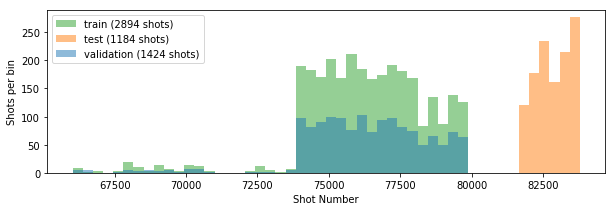

In [13]:
# Verify that all the data you are dealing with is carbon wall < 84000
fig, ax = plt.subplots(figsize=(10,3))

data = [shotlist_file.f.shot_list_validate,
        shotlist_file.f.shot_list_test,
        shotlist_file.f.shot_list_train]

data = [[s.number for s in f] for f in data]
labels = ['validation', 'test', 'train']
labels = [l+' ('+str(len(d))+' shots)' for (l,d) in zip(labels,data)]
ax.hist(data, label=labels, bins=50, alpha=0.5, histtype='stepfilled')
ax.legend(loc='upper left')
ax.set_xlabel('Shot Number')
ax.set_ylabel('Shots per bin')

max_shotnr = max([max(d) for d in data])
print(max_shotnr)
fig.savefig(outdir+'runs.png', dpi=300)

In [14]:
shotlist_val = shotlist_file.f.shot_list_validate

In [15]:
shot = shotlist_val[0]

In [16]:
pprint(shot.__dict__)

{'augmentation_fn': None,
 'is_disruptive': False,
 'machine': jet,
 'number': 75465,
 'signals': [q95 safety factor,
             internal inductance,
             plasma current,
             stored energy,
             Locked mode amplitude,
             Plasma density,
             Radiated Power Core,
             Radiated Power Edge,
             Radiated Power,
             Input Power (beam for d3d),
             stored energy time derivative],
 'signals_dict': None,
 't_disrupt': -1.0,
 'ttd': None,
 'valid': True,
 'weight': 1.0}


### Machines

In [17]:
jet = shot.signals[0].machines[0]
d3d = shot.signals[0].machines[1]

In [18]:
shot.machine.__dict__

{'name': 'jet',
 'server': 'mdsplus.jet.efda.org',
 'max_cores': 8,
 'fetch_data_fn': <function data.signals.fetch_jet_data(signal_path, shot_num, c)>,
 'current_threshold': 100000.0}

In [19]:
d3d.__dict__

{'name': 'd3d',
 'server': 'atlas.gat.com',
 'max_cores': 32,
 'fetch_data_fn': <function data.signals.fetch_d3d_data(signal_path, shot, c=None)>,
 'current_threshold': 0.2}

### Signals

In [20]:
df_jet_signals = []
df_d3d_signals = []

for sig in shot.signals:
    df = pd.DataFrame(sig.__dict__)
    row_jet = df.query('machines==@jet')
    row_d3d = df.query('machines==@d3d')
    if len(row_jet)==1:
        df_jet_signals.append(row_jet)
    if len(row_d3d)==1:
        df_d3d_signals.append(row_d3d)

In [21]:
df_jet_signals = pd.concat(df_jet_signals, sort=False, ignore_index=True,copy=False)
df_jet_signals

,description,paths,machines,causal_shifts,is_ip,num_channels,normalize,data_avail_tolerances,is_strictly_positive,mapping_paths,channel_nums
0,q95 safety factor,ppf/efit/q95,jet,15,False,1,False,0.03,False,None,NaN
1,internal inductance,jpf/gs/bl-li<s,jet,0,False,1,True,0.00,False,None,NaN
2,plasma current,jpf/da/c2-ipla,jet,0,True,1,True,0.00,False,None,NaN
3,stored energy,jpf/gs/bl-wmhd<s,jet,0,False,1,True,0.00,False,None,NaN
4,Locked mode amplitude,jpf/da/c2-loca,jet,0,False,1,True,0.00,False,None,NaN
5,Plasma density,jpf/df/g1r-lid:003,jet,0,False,1,True,0.00,True,None,NaN
6,Radiated Power Core,ppf/bolo/kb5h,jet,0,False,1,True,0.00,False,None,14.0
7,Radiated Power Edge,ppf/bolo/kb5h,jet,0,False,1,True,0.00,False,None,10.0
8,Radiated Power,jpf/db/b5r-ptot>out,jet,0,False,1,True,0.00,False,None,NaN
9,Input Power (beam for d3d),jpf/gs/bl-ptot<s,jet,0,False,1,True,0.00,False,None,NaN


In [22]:
df_jet_signals.description.to_list()

['q95 safety factor',
 'internal inductance',
 'plasma current',
 'stored energy',
 'Locked mode amplitude',
 'Plasma density',
 'Radiated Power Core',
 'Radiated Power Edge',
 'Radiated Power',
 'Input Power (beam for d3d)',
 'stored energy time derivative']

In [23]:
# WARNING: This list will only be complete if the input processed data contains at least one DII-D shot!
df_d3d_signals = pd.concat(df_d3d_signals, sort=False, ignore_index=True,copy=False)
df_d3d_signals

,description,paths,machines,causal_shifts,is_ip,num_channels,normalize,data_avail_tolerances,is_strictly_positive,mapping_paths,channel_nums
0,q95 safety factor,EFIT01/RESULTS.AEQDSK.Q95,d3d,10,False,1,False,0.02,False,None,NaN
1,internal inductance,d3d/efsli,d3d,0,False,1,True,0.00,False,None,NaN
2,plasma current,d3d/ipspr15V,d3d,0,True,1,True,0.00,False,None,NaN
3,stored energy,d3d/efswmhd,d3d,0,False,1,True,0.00,False,None,NaN
4,Locked mode amplitude,d3d/dusbradial,d3d,0,False,1,True,0.00,False,None,NaN
5,Plasma density,d3d/dssdenest,d3d,0,False,1,True,0.00,True,None,NaN
6,Radiated Power Core,d3d/\bol_l15_p,d3d,0,False,1,True,0.00,False,None,NaN
7,Radiated Power Edge,d3d/\bol_l03_p,d3d,0,False,1,True,0.00,False,None,NaN
8,Input Power (beam for d3d),d3d/bmspinj,d3d,0,False,1,True,0.00,False,None,NaN


### Shots

In [27]:
shots_dir = indir+'processed_shots/signal_group_3236450206765786377241194018831785328/'
#all_files = glob.glob(shots_dir+'*.npz')
#vars(file)

Create a list of n disruptive and n nondisrutpive shots, taken from the jet validation set

In [28]:
disruptive_files = []
disruptive_shots = []

non_disruptive_files = []
non_disruptive_shots = []

max_n = 5

counter=0
for shot in shotlist_val:
    if len(disruptive_files)>max_n-1:
        break
        
    counter+=1
    clear_output(wait=True)
    
    if(shot.valid and shot.machine==jet):
        if shot.is_disruptive:
            file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True)
            disruptive_files.append(file)
            disruptive_shots.append(shot)
        elif(len(non_disruptive_files)<max_n):
            file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True)
            non_disruptive_files.append(file)
            non_disruptive_shots.append(shot)
        
    print('Found',len(disruptive_files), 'disruptions out of', counter, 'shots.')

Found 5 disruptions out of 73 shots.


In [22]:
index = 1
file = disruptive_files[index]
shot = disruptive_shots[index]

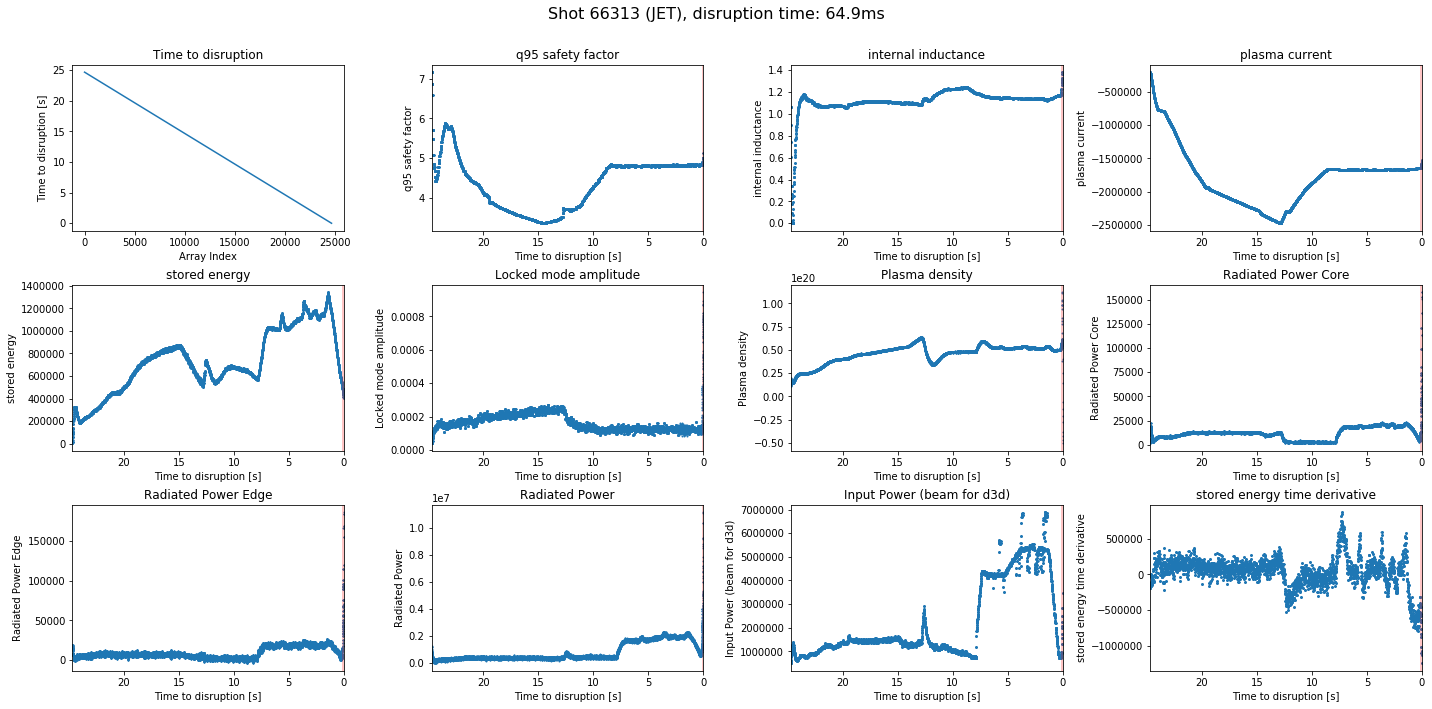

In [31]:
for shot, file in zip(disruptive_shots, disruptive_files):
    plot_shot(shot,file)
    break

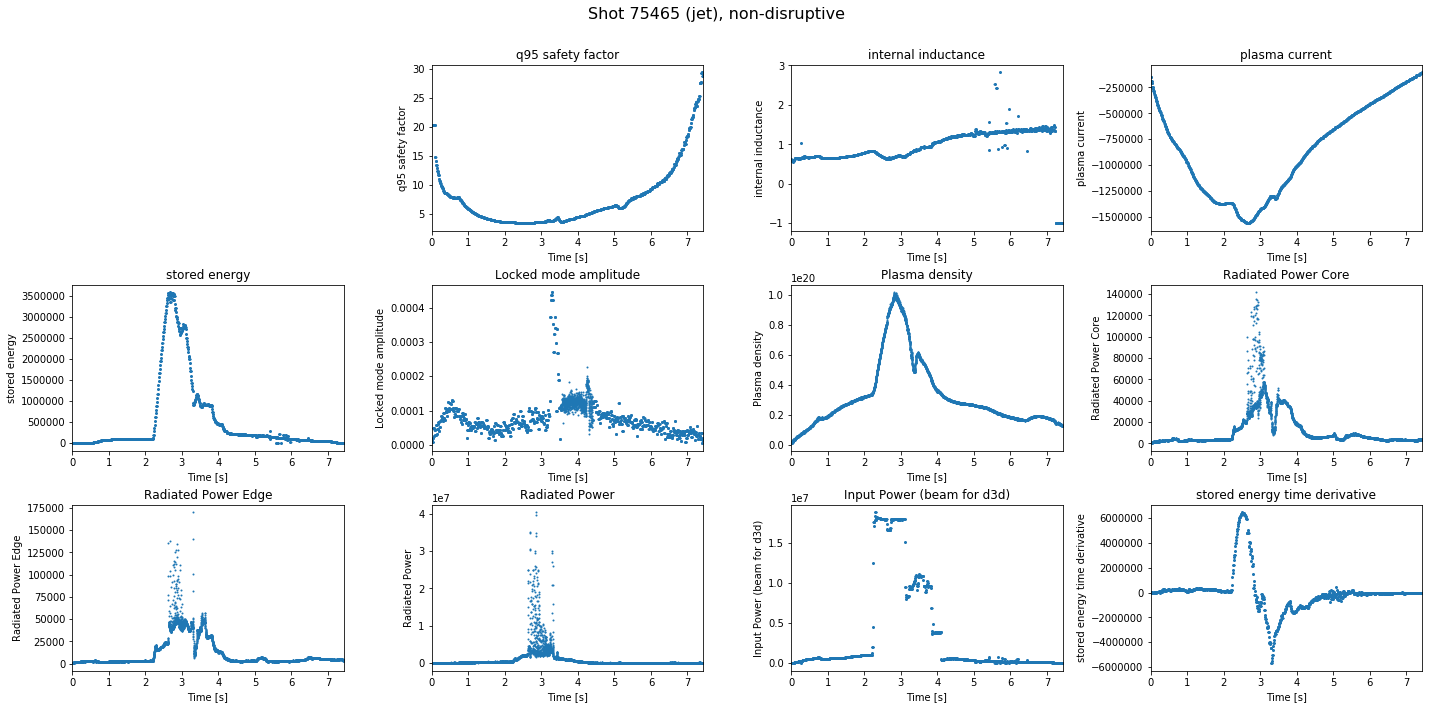

In [32]:
for shot, file in zip(non_disruptive_shots, non_disruptive_files):
    plot_shot(shot,file)
    break

### Look at the FFT of the signals

For one specific file

In [39]:
file = disruptive_files[2]
signals_dict = file.f.signals_dict.item(0).items()
N = len(file.f.ttd)

In [40]:
file.__dict__

{'_files': ['valid.npy', 'is_disruptive.npy', 'signals_dict.npy', 'ttd.npy'],
 'files': ['valid', 'is_disruptive', 'signals_dict', 'ttd'],
 'allow_pickle': True,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='/tigress/wvdp/processed_shots/signal_group_3236450206765786377241194018831785328/73703.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x2b35fa1da780>,
 'fid': <_io.BufferedReader name='/tigress/wvdp/processed_shots/signal_group_3236450206765786377241194018831785328/73703.npz'>}

51


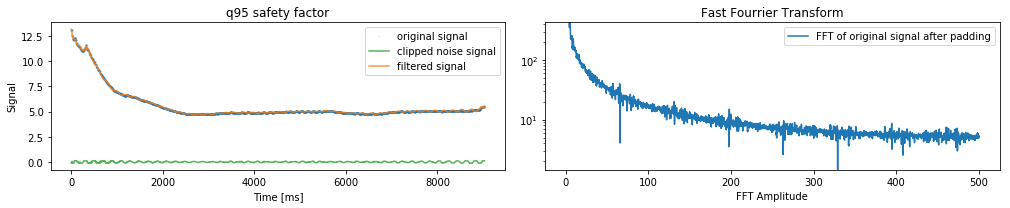

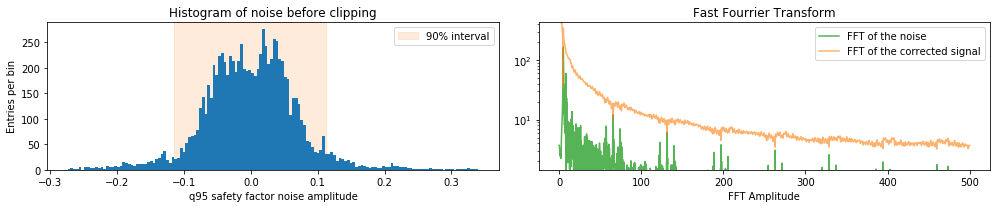

51


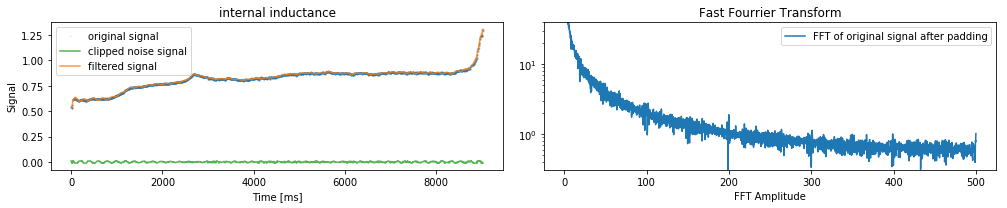

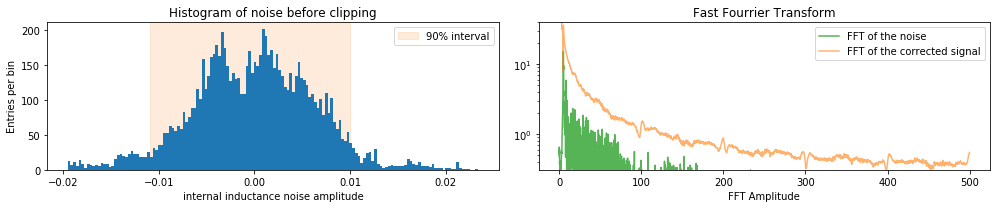

51


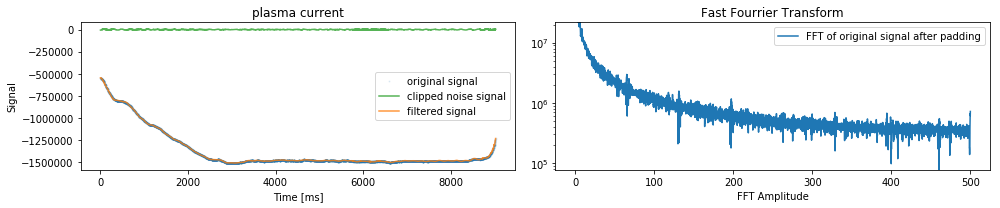

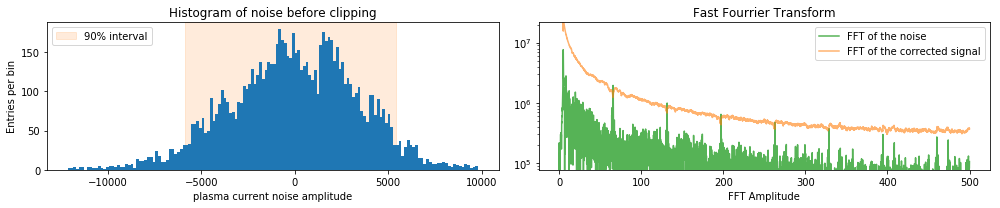

51


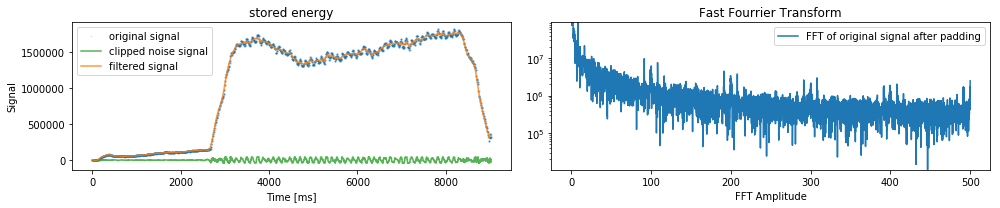

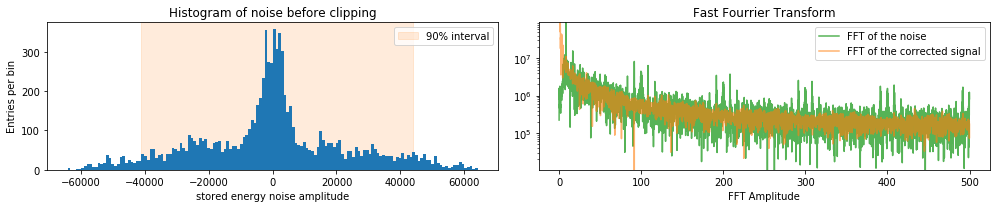

51


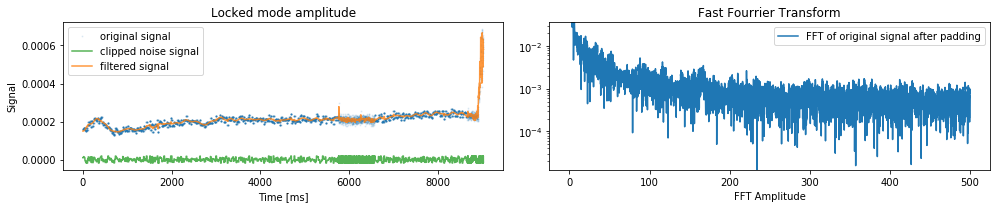

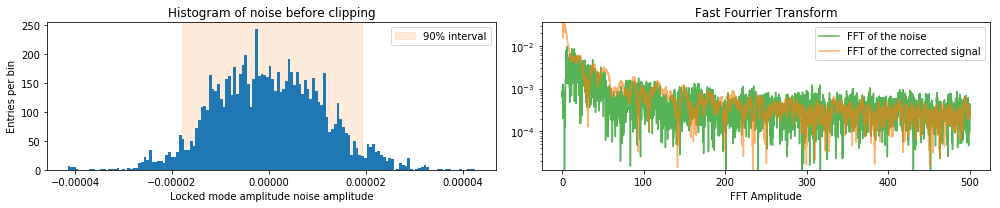

51


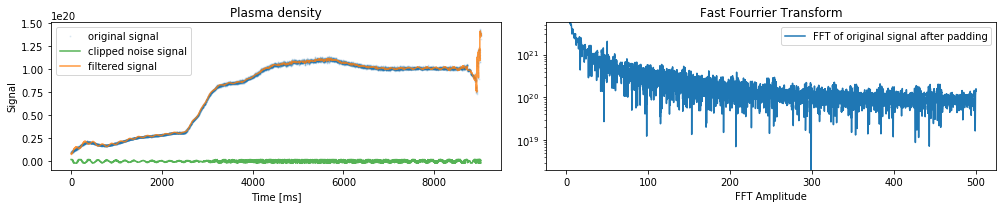

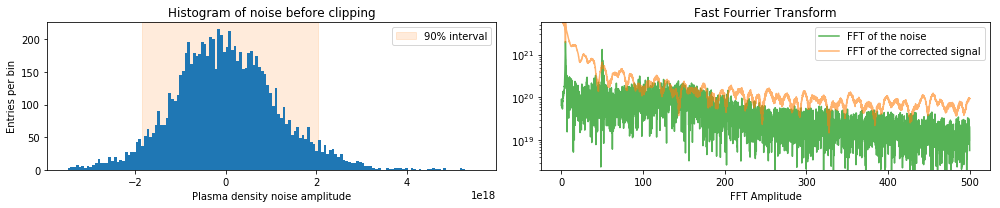

51


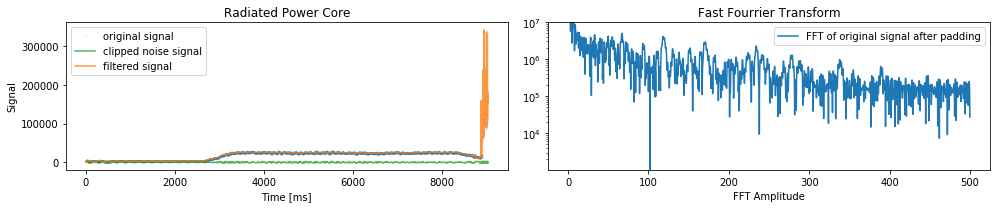

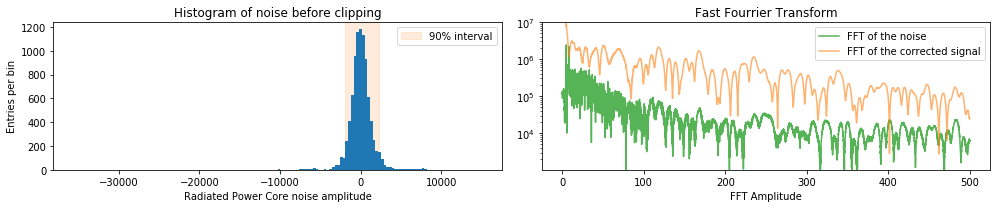

51


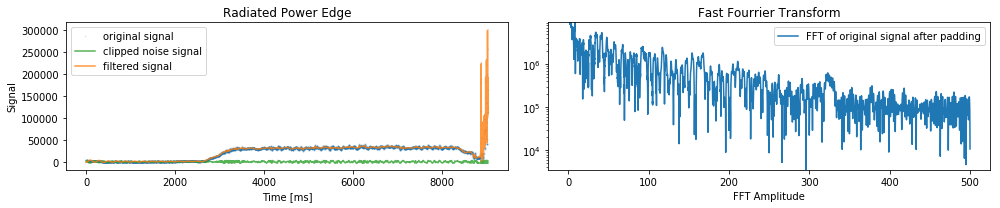

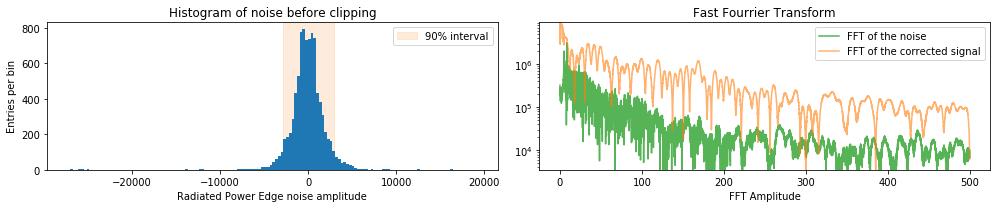

51


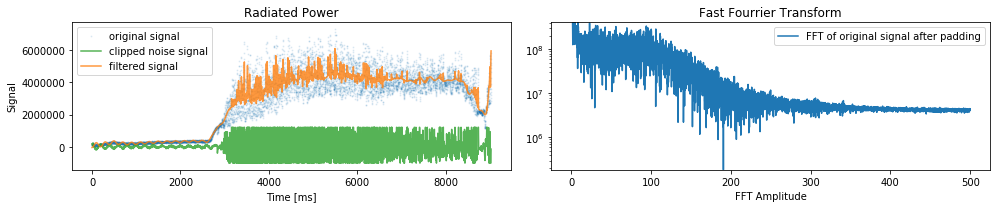

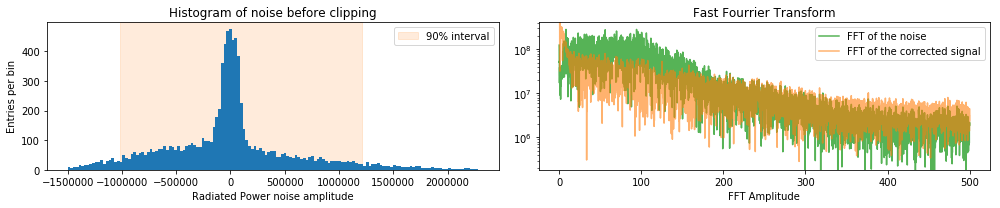

51


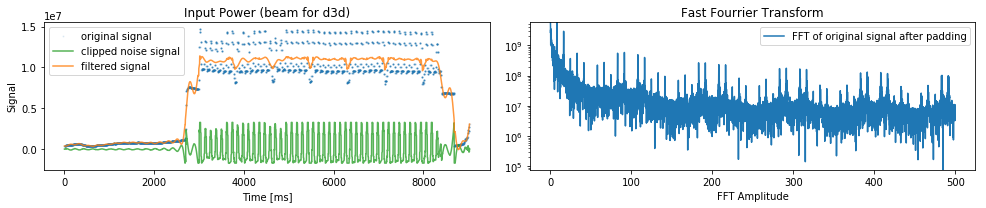

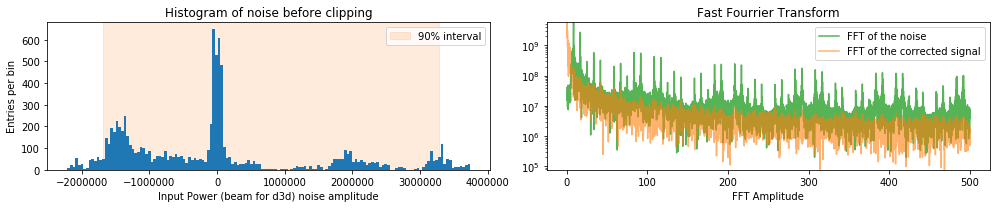

51


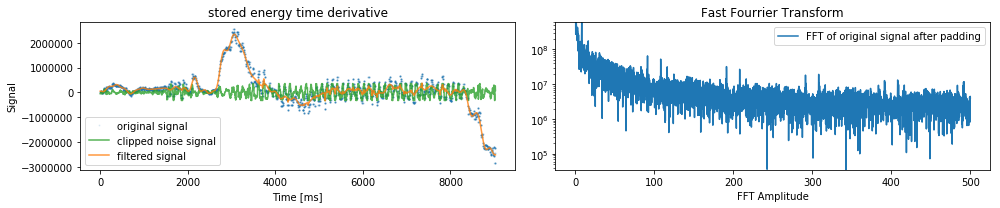

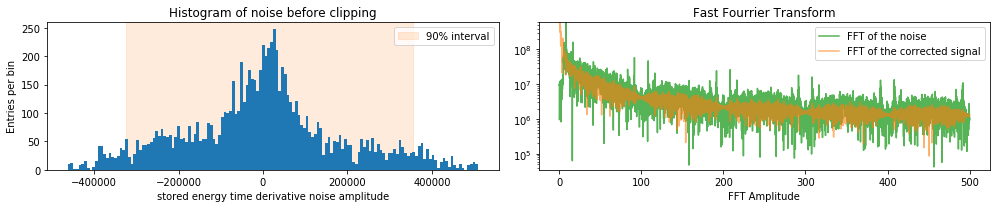

In [41]:
for i,(k,v) in enumerate(signals_dict):
    fig, ax = plt.subplots(ncols=2, figsize=(14,3))

    sig = v.flatten()
    freq, freq_padded, fftsig, noise, noise_clip = calculate_noise(sig, fft_params)
    
    # Plot original signal on top
    ax[0].plot(sig, '.', markersize=2, label='original signal', alpha=0.1)
    ax[0].set_title(k)
    ax[0].set_xlabel('Time [ms]')
    ax[0].set_ylabel('Signal')

    # FFT of real valued serie is symmetric, only plot first half (rfft)
    fftsig_abs = np.abs(fftsig)
    ax[1].plot(freq_padded, fftsig_abs, label='FFT of original signal after padding')
    ax[1].set_ylim(min(fftsig_abs),max(fftsig_abs[50:]))
    ax[1].set_title('Fast Fourrier Transform')
    ax[1].set_xlabel(r'Frequency [Hz$^{-1}$]')
    ax[1].set_xlabel(r'FFT Amplitude')
    ax[1].set_yscale('log')
    ax[1].legend()

    plot_lower,lower, upper, plot_upper = np.percentile(noise,(0.5,5,95,99.5))
    
    ax[0].plot(noise_clip, label='clipped noise signal', alpha=0.8, color='C2')
    ax[0].plot(sig-noise_clip, label='filtered signal', alpha=0.8, color='C1')
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir+'fft/'+str(k).replace(" ", "")+'_fft.png', dpi=300)
    fig.show()

    fig, ax = plt.subplots(ncols=2, figsize=(14,3))
    ax[0].axvspan(xmin=lower, xmax=upper,color='C1', alpha=0.15, label='90% interval')
    ax[0].hist(noise, bins=150, range=(plot_lower, plot_upper))
    ax[0].set_title('Histogram of noise before clipping')
    ax[0].legend()
    ax[0].set_xlabel(str(k)+' noise amplitude')
    ax[0].set_ylabel('Entries per bin')
    
    freq = rfftfreq(len(noise_clip), d=fft_params['time_step'])
    ax[1].plot(freq, abs(rfft(noise_clip)), label='FFT of the noise', alpha=0.8, color='C2')
    ax[1].plot(freq, abs(rfft(sig-noise_clip)), label='FFT of the corrected signal', alpha=0.6, color='C1')
    ax[1].set_ylim(min(fftsig_abs),max(fftsig_abs[50:]))
    ax[1].set_xlabel(r'Frequency [Hz$^{-1}$]')
    ax[1].legend()
    ax[1].set_yscale('log')
    ax[1].set_title('Fast Fourrier Transform')
    ax[1].set_xlabel(r'FFT Amplitude')

    fig.tight_layout()
    fig.savefig(outdir+'fft_noise/'+str(k).replace(" ", "")+'_fft_noise.png', dpi=300)
    plt.show()

### Plot the noise over time

In [28]:
shots = np.concatenate([shotlist_file.f.shot_list_validate,
                        shotlist_file.f.shot_list_train,
                        shotlist_file.f.shot_list_test])

In [29]:
start = time.time()

num_jet_sig = len(df_jet_signals)

counter_no = 0
counter_yes = 0
N_shots_non_disruptive = sum([~shot.is_disruptive for shot in shots])
N_shots_disruptive = sum([shot.is_disruptive for shot in shots])

stats_non_disruptive = np.empty((num_jet_sig,N_shots_non_disruptive,7))
stats_disruptive = np.empty((num_jet_sig,N_shots_disruptive,7))

for shot in shots:
    if(shot.valid and shot.machine==jet):
        
        file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True) 
        signals_dict = list(file.f.signals_dict.item(0).items())
        
        for i in range(num_jet_sig):
            sig = signals_dict[i][1].flatten()
            freq, freq_padded, fftsig, noise, noise_clip = calculate_noise(sig, fft_params)
            plot_lower,lower, middle, upper, plot_upper = np.percentile(noise,(0.5,5,50,95,99.5))

            if shot.is_disruptive:
                stats_disruptive[i][counter_yes] = [shot.number, len(sig), 
                                                    plot_lower,lower, middle, upper, plot_upper]
                
            else:
                stats_non_disruptive[i][counter_no] = [shot.number, len(sig), 
                                                       plot_lower,lower, middle, upper, plot_upper]
        if shot.is_disruptive:    
            counter_yes+=1
        else:
            counter_no+=1
                
        clear_output(wait=True)
        print('Non-disruptive:\t',counter_no, '/',N_shots_non_disruptive)
        print('Disruptive:\t',counter_yes, '/',N_shots_disruptive)
        
end = time.time()
print('Time passed: {:.1f}s'.format(end - start))

Non-disruptive:	 5023 / 5023
Disruptive:	 479 / 479
Time passed: 289.8s


q95 safety factor
internal inductance
plasma current
stored energy
Locked mode amplitude
Plasma density
Radiated Power Core
Radiated Power Edge
Radiated Power
Input Power (beam for d3d)
stored energy time derivative


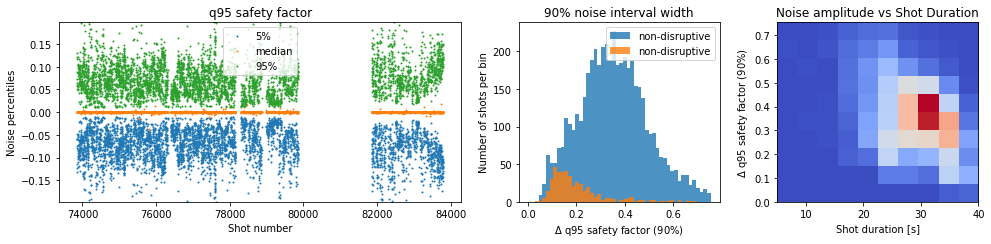

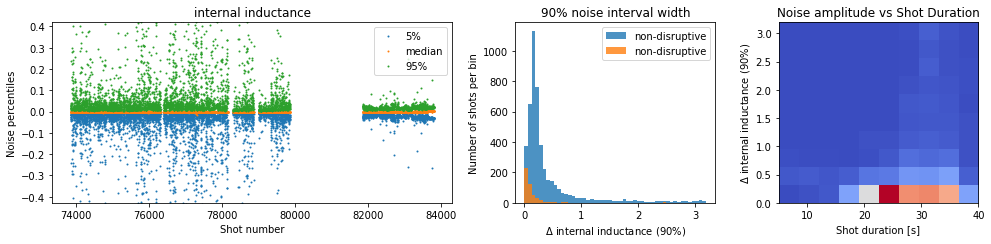

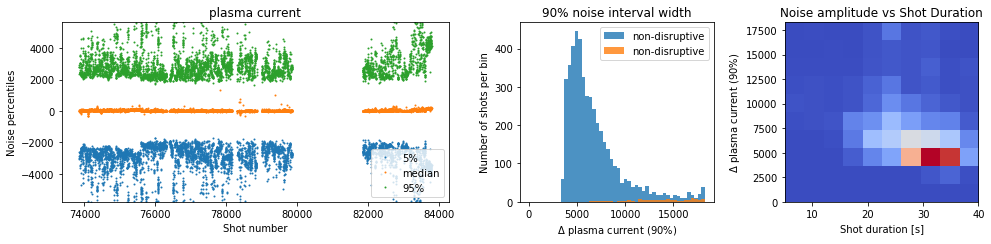

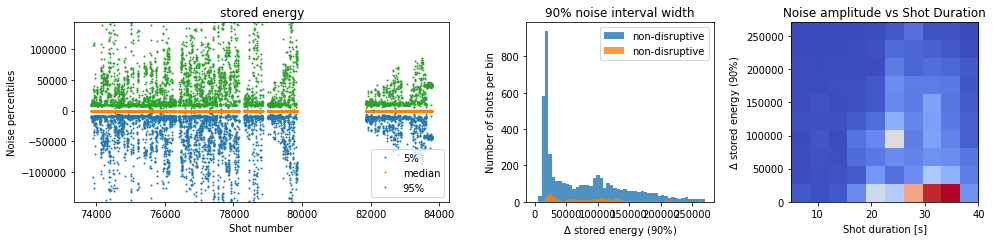

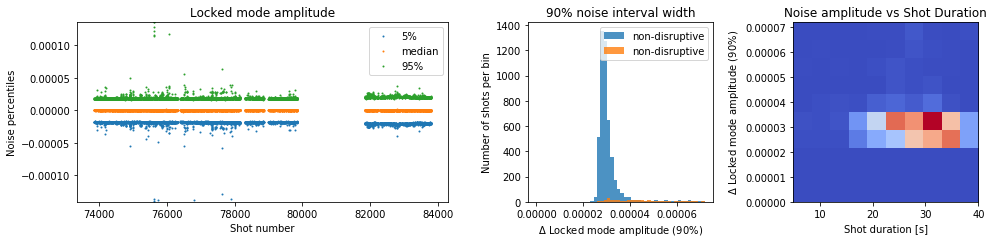

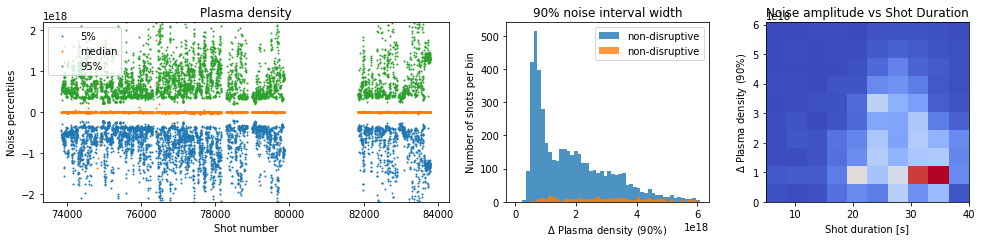

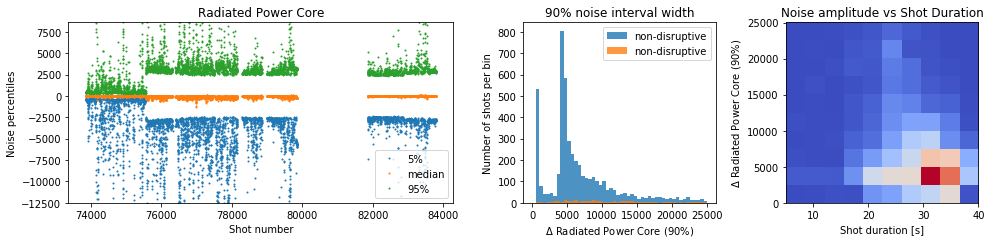

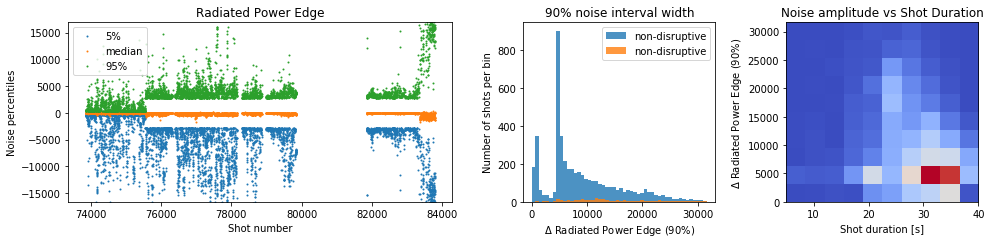

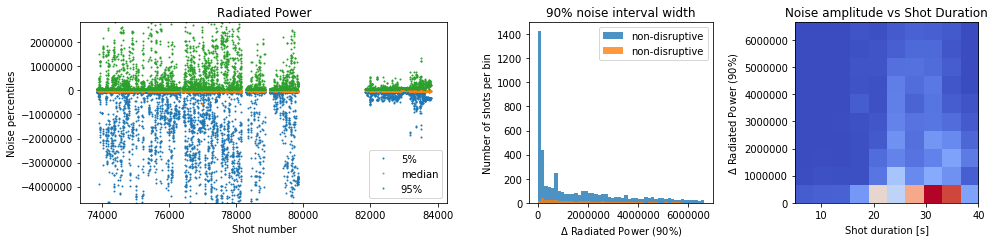

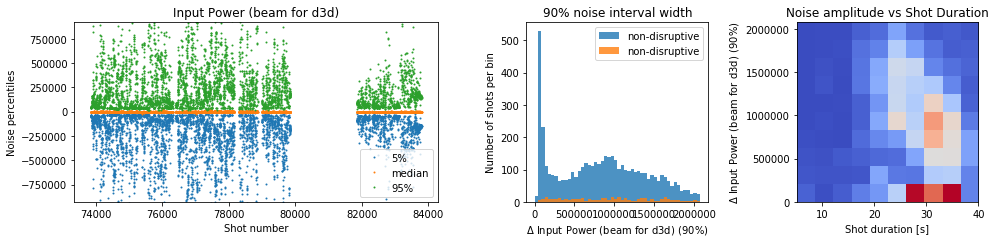

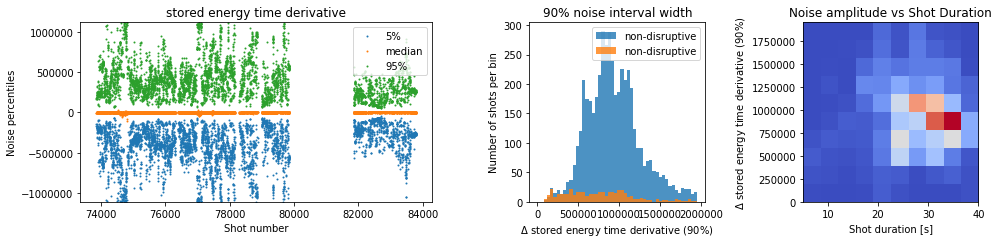

In [30]:
for i_sig in range(num_jet_sig):
    fig, ax = plt.subplots(ncols=3, figsize=(14,3.5), gridspec_kw={'width_ratios':[2,1,1]})

    sig_str = df_jet_signals['description'][i_sig]
    print(sig_str)
    array_non_disruptive = np.array(stats_non_disruptive[i_sig]).T
    array_disruptive = np.array(stats_disruptive[i_sig]).T
    
    x_arr = array_non_disruptive[0]
    len_arr = array_non_disruptive[1]
    data = array_non_disruptive[[3,4,5]]
    lab = ['5%','median', '95%']
    for d,l in zip(data,lab):
        ax[0].plot(x_arr, d, '.', label=l, markersize=2)
    ax[0].legend()
    ax[0].set_xlabel('Shot number')
    ax[0].set_ylabel('Noise percentiles')
    ax[0].set_title(sig_str)
    l_y = np.percentile(data[0],2.5)
    h_y = np.percentile(data[2],97.5)
    ax[0].set_ylim(l_y, h_y)

    var = array_non_disruptive[4] - array_non_disruptive[2]
    var_disruptive = array_disruptive[4] - array_disruptive[2]
    upper_x = np.percentile(var,95)
    
    ax[1].hist(var,bins=50, range=(0,upper_x),alpha=0.8, label='non-disruptive')
    ax[1].hist(var_disruptive,bins=50, range=(0,upper_x),alpha=0.8, label='non-disruptive')
    ax[1].legend()
    ax[1].set_title("90% noise interval width")
    ax[1].set_ylabel('Number of shots per bin')
    ax[1].set_xlabel(r"$\Delta$ "+sig_str+" (90%)")

    ax[2].hist2d(len_arr/1000,var, range=((5,40),(0,upper_x)), cmap='coolwarm')
    ax[2].set_ylabel(r"$\Delta$ "+sig_str+" (90%)")
    ax[2].set_xlabel("Shot duration [s]")
    ax[2].set_title('Noise amplitude vs Shot Duration')

    fig.tight_layout()
    fig.savefig(outdir+str(sig_str).replace(" ", "")+'_noise_dependence.png', dpi=300)

### Done!
Sandbox...

In [33]:
def plot_sig_fft(shotlist, shot_index, sig_index, fig=None, ax=None):
    shot = shotlist[shot_index]
    print('Shot: ',shot.number)
    file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True) 
    sig_data = file.f.signals_dict.item(0)[shot.signals[sig_index]].flatten()
    print('Data size: ',sig_data.shape)
    print('Signal: ',shot.signals[sig_index])
    freq_arr = rfftfreq(len(sig_data), d=fft_params['time_step'])
    fft_arr = rfft(sig_data)
    fft_abs_arr = np.abs(fft_arr)
    peaks = scipy.signal.find_peaks(fft_abs_arr, prominence=10000, distance=500)[0]
    print('Peak frequency: ',freq_arr[peaks])
    print('Peak amplitude: ',fft_abs_arr[peaks])

    if fig==None or ax==None: 
        fig, ax = plt.subplots()
    ax.plot(freq_arr, fft_arr)
    ax.set_yscale('log')
    plt.draw()
    print()

Shot:  75465
Data size:  (7433,)
Signal:  plasma current
Peak frequency:  [  0.94174627 131.44087179 262.88174358 394.59168573 474.10197767]
Peak amplitude:  [1.0779957e+08 2.1081318e+06 9.9602375e+05 6.8629850e+05 4.9807734e+05]


/home/wvdp/.conda/envs/pppl/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



Shot:  77463
Data size:  (21189,)
Signal:  plasma current
Peak frequency:  [2.35971495e-01 2.69007504e+01 6.57888527e+01 1.00099108e+02
 1.31530511e+02 1.58856010e+02 1.97224975e+02 2.38331210e+02
 2.62966634e+02 3.04072868e+02 3.28802681e+02 3.69814526e+02
 3.94544339e+02 4.32913304e+02 4.60238803e+02 4.84968616e+02]
Peak amplitude:  [8.47988544e+08 3.12949800e+06 9.89094800e+06 1.04076275e+06
 4.74643850e+06 6.32946188e+05 3.37259950e+06 5.89559812e+05
 2.17000375e+06 5.41581875e+05 1.74112275e+06 4.42543406e+05
 1.46494688e+06 4.15346469e+05 1.34372838e+06 4.08350312e+05]

Shot:  66313
Data size:  (24704,)
Signal:  plasma current
Peak frequency:  [3.23834197e-01 2.12111399e+01 4.19770078e+01 6.58193005e+01
 9.98218912e+01 1.31557642e+02 1.63171956e+02 1.97295984e+02
 2.25550518e+02 2.63074806e+02 2.97077396e+02 3.28813148e+02
 3.56217617e+02 3.94551490e+02 4.21955959e+02 4.46607837e+02
 4.73931347e+02 4.98583225e+02]
Peak amplitude:  [6.5379238e+08 1.0520730e+07 5.3368645e+06 5.174

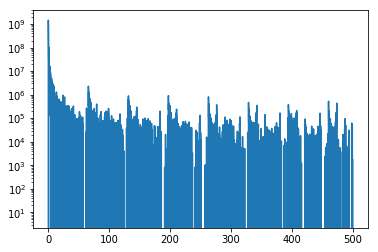

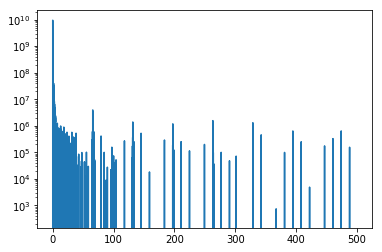

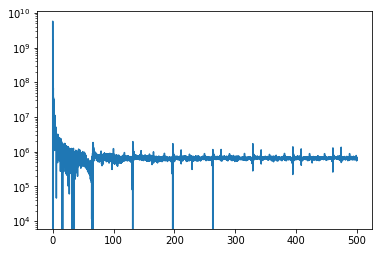

In [34]:
for i in range(3):
    plot_sig_fft(shots, i, 2) 